In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.datasets import make_circles, make_moons
from sklearn.metrics import confusion_matrix

torch.__version__

'1.12.0'

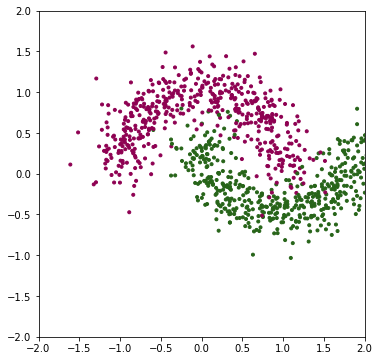

In [2]:
# X, Y = make_circles(n_samples=1000,
#                     shuffle=True,
#                     noise=.1,
#                     random_state=None,
#                     factor=0.5)

X, Y = make_moons(n_samples=1000,
                  shuffle=True,
                  noise=.2,
                  random_state=None)

X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y).view(-1, 1)

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=Y, marker='.', cmap='PiYG')
plt.axis('square')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [3]:
class CircleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [4]:
# hidden_cfg = [256,64,16,4]
hidden_cfg = [32,16,8,4,8,16,32]
activation = nn.Mish()

class NeuralNetwork(nn.Module):
    def __init__(self, layers: nn.Module):
        super(NeuralNetwork, self).__init__()
        self.layers = layers
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

def make_layers(hidden_cfg, activation) -> nn.Sequential:
    layers_cfg = [2, *hidden_cfg, 1]
    layers = []
    for i in range(len(layers_cfg)-1):
        in_features, out_features = layers_cfg[i], layers_cfg[i+1]
        layers.append(nn.Linear(in_features, out_features, bias=True))
        if i == len(layers_cfg)-2:
            break
        layers.append(activation)
    return nn.Sequential(*layers)

model = NeuralNetwork(make_layers(hidden_cfg, activation))
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Mish()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Mish()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Mish()
    (6): Linear(in_features=8, out_features=4, bias=True)
    (7): Mish()
    (8): Linear(in_features=4, out_features=8, bias=True)
    (9): Mish()
    (10): Linear(in_features=8, out_features=16, bias=True)
    (11): Mish()
    (12): Linear(in_features=16, out_features=32, bias=True)
    (13): Mish()
    (14): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [5]:
dataset = CircleDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=False)

optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=0.9, nesterov=True)
loss_fn = nn.BCELoss()
epochs = 5000

for epoch in range(epochs):
    running_loss = 0
    for batch, (points, actuals) in enumerate(dataloader):
        optimizer.zero_grad()

        predicted = model(points)

        loss = loss_fn(torch.sigmoid(predicted), actuals)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 500 == 499:
        print(f'[epoch{epoch+1:>5}/{epochs}] {running_loss/len(dataset):>7f}')


[epoch  500/5000] 0.000925
[epoch 1000/5000] 0.000866
[epoch 1500/5000] 0.000828
[epoch 2000/5000] 0.000783
[epoch 2500/5000] 0.000707
[epoch 3000/5000] 0.000706
[epoch 3500/5000] 0.000712
[epoch 4000/5000] 0.000754
[epoch 4500/5000] 0.000692
[epoch 5000/5000] 0.000667


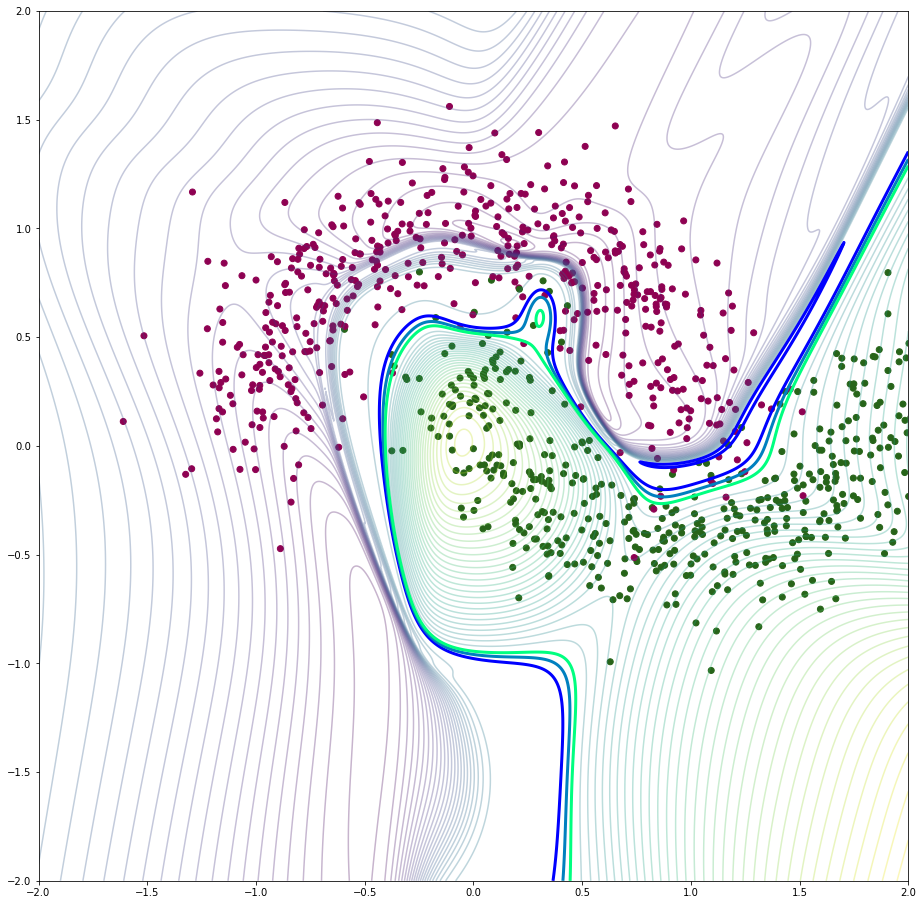

In [6]:
model.eval()

grain = 1000
x = torch.linspace(-2, 2, grain)
y = torch.linspace(-2, 2, grain)
xx, yy = torch.meshgrid(x, y, indexing='xy')

Z = torch.cat([xx.view(grain,grain,1), yy.view(grain,grain,1)], dim=2)
Z = model(Z.view(-1,2)).detach()
Z = Z.view(grain,grain)

plt.figure(figsize=(16,16))
plt.scatter(X[:,0], X[:,1], c=Y, marker='o', cmap='PiYG')
plt.contour(xx, yy, Z, 70, cmap='viridis', alpha=.3)
plt.contour(xx, yy, Z, 70, levels=[0, 0.5, 1.0], cmap='winter', linewidths=3.0)
plt.axis('square')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [7]:
confusion_matrix((torch.sigmoid(model(X))>0.5).flatten(), Y)

array([[484,  14],
       [ 16, 486]])